In [1]:
import cv2
import numpy as np
import os
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
from PIL import Image
import matplotlib.pyplot as plt

The OS module in Python provides a way of using operating system dependent functionality.
Python method listdir() returns a list containing the names of the entries in the directory given by path.
os.chdir() method in Python used to change the current working directory to specified path.

In [2]:
print(os.getcwd()) 

C:\Users\tetal\AI


In [3]:
# Folder which contains all the images 
# from which video is to be generated  
path = "C:\\Users\\tetal\\AI\\Test001"
os.chdir(path)

In [4]:
mean_height = 0
mean_width = 0

num_of_images = len(os.listdir('.')) 
print(num_of_images) 

202


In [5]:
image_folder = 'C:\\Users\\tetal\\AI\\Test001' # make sure to use your folder 
video_name = 'mygeneratedvideo2.mp4'
#os.chdir("C:\\Users\\tetal\\AI") 
images = [img for img in os.listdir(path) 
if img.endswith(".tif") or
    img.endswith(".jpeg") or
    img.endswith("png")] 
#print(images)

In [8]:
for file in os.listdir('.'): 
    im = Image.open(os.path.join(path, file)) 
    width, height = im.size 
    mean_width += width 
    mean_height += height 
    # im.show() # uncomment this for displaying the image 

# Finding the mean height and width of all images. 
# This is required because the video frame needs 
# to be set with same width and height. Otherwise 
# images not equal to that width height will not get 
# embedded into the video 
mean_width = int(mean_width / num_of_images) 
mean_height = int(mean_height / num_of_images) 

# print(mean_height) 
# print(mean_width) 

# Resizing of the images to give 
# them same width and height 
for file in os.listdir('.'): 
    if file.endswith(".tif") or file.endswith(".jpeg") or file.endswith("png"): 
        # opening image using PIL Image 
        im = Image.open(os.path.join(path, file)) 

        # im.size includes the height and width of image 
        width, height = im.size 
        print(width, height) 

        # resizing 
        imResize = im.resize((238, 158), Image.ANTIALIAS) 
        imResize.save( file, "JPEG",quality = 95) # setting quality 
        # printing each resized image name 
        print(im.filename.split('\\')[-1], " is resized") 


238 158
001.tif  is resized
238 158
002.tif  is resized
238 158
003.tif  is resized
238 158
004.tif  is resized
238 158
005.tif  is resized
238 158
006.tif  is resized
238 158
007.tif  is resized
238 158
008.tif  is resized
238 158
009.tif  is resized
238 158
010.tif  is resized
238 158
011.tif  is resized
238 158
012.tif  is resized
238 158
013.tif  is resized
238 158
014.tif  is resized
238 158
015.tif  is resized
238 158
016.tif  is resized
238 158
017.tif  is resized
238 158
018.tif  is resized
238 158
019.tif  is resized
238 158
020.tif  is resized
238 158
021.tif  is resized
238 158
022.tif  is resized
238 158
023.tif  is resized
238 158
024.tif  is resized
238 158
025.tif  is resized
238 158
026.tif  is resized
238 158
027.tif  is resized
238 158
028.tif  is resized
238 158
029.tif  is resized
238 158
030.tif  is resized
238 158
031.tif  is resized
238 158
032.tif  is resized
238 158
033.tif  is resized
238 158
034.tif  is resized
238 158
035.tif  is resized
238 158
036.tif  is 

In [9]:
# Video Generating function 
def generate_video(images,outvid=None, fps=10, size=None,
               is_color=True, format="XVID"): 
	#image_folder = 'C:\\Users\\tetal\\AI\\Test001' # make sure to use your folder 
	video_name = 'mygeneratedvideo2.mp4'
	#os.chdir("C:\\Users\\tetal\\AI\\Test001") 
	
	#images = [img for img in os.listdir(image_folder) 
			#if img.endswith(".tif") or
				#img.endswith(".jpeg") or
				#img.endswith("png")] 
	
	# Array images should only consider 
	# the image files ignoring others if any 
	#print(images) 

	frame = cv2.imread(os.path.join(image_folder, images[0])) 

	# setting the frame width, height width 
	# the width, height of first image 
	height, width, layers = frame.shape 
	fourcc = VideoWriter_fourcc(*format)
	video = VideoWriter(video_name, fourcc, float(fps), (238, 158), is_color)

	# Appending the images to the video one by one 
	for image in images: 
		video.write(cv2.imread(os.path.join(image_folder, image))) 
	
	# Deallocating memories taken for window creation 
	cv2.destroyAllWindows() 
    
	video.release() # releasing the video generated 



In [10]:
# Calling the generate_video function 
generate_video(images) 

# Sparse Optical Flow

In [11]:
cap = cv2.VideoCapture('mygeneratedvideo2.mp4')

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 25,
                       qualityLevel = 0.2,
                       minDistance = 4,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

count=0
index = 0;
ret,frame = cap.read()
while(ret):
   
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    #print(err)
    # Select good points
    good_new = p1[st==1]
    #print(good_new)
    good_old = p0[st==1]
    #print(good_old)
    
    
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        
        
        a,b = new.ravel()
        #print(a,b)
        c,d = old.ravel()
        #print(c,d)

        #print(c-a,d-b)
        if((a>c) & (b>d)):
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    #print(p0)
    ret,frame = cap.read()
    
cv2.destroyAllWindows()
cap.release()

# Dense Optical Flow

In [15]:
cap = cv2.VideoCapture("mygeneratedvideo2.mp4")
ret, frame1 = cap.read() #returns a bool (True/False). If frame is read correctly, it will be True. So you can check end of the video by checking this return value.
#print(frame1.shape)
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1) # Return a array of zeros of same type and shape as given array
hsv[...,1] = 255
count=0
index = 0;
ret, frame2 = cap.read()
mag_fullarray = []
print(mag_fullarray)
while(ret):
   
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY) #For BGR \rightarrow Gray conversion we use the flags cv2.COLOR_BGR2GRAY

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    #prvs = next;
    pixel_array = np.array(flow)
    #print(pixel_array[0].shape)
    #print ("flow",flow)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    print("magnitude",mag)
    #print(mag.shape)
    mag_fullarray.append(mag)
    #mag_array = np.array(mag)
    #print(mag_array.shape)
    #print("mag",mag.shape)
    #plt.hist(mag_array,bins=3)
    #plt.show()
    #print(len((mag_array)))
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    #print(hsv)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    #if count==10:
        #count=0
        
       # print ("flow",flow)
        
    cv2.imshow('frame2',rgb)
    count=count+1
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):    
        prvs = next
    ret, frame2 = cap.read()
    index = index+1
    #print(index)

print("magfullarray",mag_fullarray[0])
cap.release()
cv2.destroyAllWindows()

[]
magnitude [[0.0834119  0.08460433 0.07279027 ... 0.16629252 0.21113469 0.22412148]
 [0.09120043 0.08931893 0.07322425 ... 0.11158067 0.15838037 0.1869983 ]
 [0.08706678 0.07705993 0.05819938 ... 0.06911873 0.10996211 0.14955103]
 ...
 [0.01618366 0.02415204 0.02376142 ... 0.04385336 0.04512104 0.04112227]
 [0.01387305 0.02017737 0.01916961 ... 0.03663157 0.03830455 0.03483986]
 [0.01318153 0.01921904 0.01750292 ... 0.01786355 0.01909427 0.01624233]]
magnitude [[0.07664917 0.06790832 0.05208775 ... 0.04732241 0.09164227 0.08714285]
 [0.09922954 0.08554817 0.06809323 ... 0.06384761 0.12364472 0.1381893 ]
 [0.07806775 0.06366622 0.06141017 ... 0.03593039 0.19743231 0.21689495]
 ...
 [0.00581553 0.01027117 0.01751171 ... 0.03709358 0.03240996 0.03337999]
 [0.00430731 0.00827414 0.01458845 ... 0.02270941 0.01919531 0.01742567]
 [0.00465941 0.00482955 0.01054627 ... 0.02413015 0.02183188 0.02138149]]
magnitude [[0.10795216 0.08590674 0.03592021 ... 0.04353512 0.03666683 0.04334382]
 [0.11

magnitude [[0.27512196 0.2710044  0.22750604 ... 0.5246875  0.43571487 0.43758437]
 [0.254224   0.23547648 0.19204496 ... 0.49976054 0.46502468 0.73219913]
 [0.23486894 0.20486738 0.16809578 ... 0.51399523 0.6313535  1.0846326 ]
 ...
 [3.766497   4.04951    4.24555    ... 0.11905839 0.11602572 0.11300974]
 [3.313494   3.581794   3.8870192  ... 0.08608679 0.08273118 0.07947202]
 [2.102706   2.432954   2.9046474  ... 0.06738018 0.06620402 0.0657377 ]]
magnitude [[0.27907407 0.2840613  0.24087445 ... 0.500125   0.4015923  0.48800898]
 [0.2708857  0.25852394 0.21118271 ... 0.47830635 0.43418014 0.8815047 ]
 [0.2568661  0.22763048 0.18521428 ... 0.48664445 0.645759   1.2290533 ]
 ...
 [5.2768354  5.282627   5.2223625  ... 0.13688293 0.1330968  0.12552488]
 [4.681006   4.788371   4.8352494  ... 0.1146397  0.10871661 0.1006092 ]
 [3.1183422  3.4404135  3.671727   ... 0.08542436 0.07791489 0.07275873]]
magnitude [[0.4025694  0.390086   0.33247095 ... 0.658403   0.5431237  0.7516662 ]
 [0.36732

magnitude [[0.16633324 0.16399243 0.13376708 ... 0.587556   0.46349555 0.4055219 ]
 [0.15763396 0.13865378 0.1046124  ... 0.8604642  0.72688895 0.67440796]
 [0.16324584 0.12312938 0.08652151 ... 1.2356278  1.0061816  0.8584613 ]
 ...
 [0.16424072 0.37235925 1.1938393  ... 0.08634711 0.07229605 0.06271514]
 [0.1409962  0.3168821  1.0299402  ... 0.07767352 0.06772789 0.05907961]
 [0.15670207 0.3355263  1.0643811  ... 0.05881343 0.05190442 0.04547879]]
magnitude [[0.17275596 0.1753851  0.15114468 ... 0.577496   0.47124785 0.3902649 ]
 [0.1802384  0.15536301 0.1216072  ... 0.85186696 0.72654706 0.6551072 ]
 [0.18736754 0.14192046 0.10752945 ... 1.2579435  1.0395896  0.8670436 ]
 ...
 [0.5160827  0.8343307  0.94947416 ... 0.1030522  0.09166749 0.09134099]
 [0.4050398  0.66161567 0.7387552  ... 0.08681922 0.07597456 0.07213924]
 [0.39449927 0.6477956  0.7193547  ... 0.06532811 0.05533342 0.05120112]]
magnitude [[0.17264777 0.16354689 0.13421227 ... 0.6237826  0.4857682  0.43271303]
 [0.18658

magnitude [[0.16480765 0.17612125 0.15760769 ... 0.2355844  0.05649695 0.08477097]
 [0.18744546 0.18789783 0.1656404  ... 0.35341585 0.2156784  0.18803386]
 [0.17293265 0.17281207 0.15818569 ... 0.570361   0.5304437  0.3426619 ]
 ...
 [0.01575249 0.01534543 0.01482395 ... 0.17076929 0.14305806 0.11908124]
 [0.00933734 0.00968092 0.01179653 ... 0.13774952 0.11157063 0.0931571 ]
 [0.01184959 0.01835404 0.02281711 ... 0.10822552 0.08077013 0.06378517]]
magnitude [[0.21705721 0.23350534 0.22292963 ... 0.2756539  0.13375229 0.00592228]
 [0.2346012  0.23919852 0.22570466 ... 0.40156302 0.2629519  0.24566714]
 [0.24806425 0.24315669 0.22922558 ... 0.61138695 0.5211241  0.41313785]
 ...
 [0.00655341 0.00323168 0.01687494 ... 0.14587824 0.12404661 0.10491186]
 [0.00265957 0.0066719  0.01624191 ... 0.119588   0.09723081 0.08073223]
 [0.00974482 0.01794631 0.02531258 ... 0.09892226 0.07449462 0.05807523]]
magnitude [[0.3030953  0.34211043 0.32216108 ... 0.23714991 0.11179125 0.0246773 ]
 [0.31635

magnitude [[0.14081004 0.14718208 0.13884537 ... 0.47870946 0.3009449  0.33150563]
 [0.13183025 0.13209057 0.12818445 ... 0.4892688  0.4215161  0.5180481 ]
 [0.15081629 0.14598036 0.13945754 ... 0.71732336 0.68498117 0.6075967 ]
 ...
 [0.03789752 0.0634606  0.07473052 ... 0.10236124 0.10368636 0.1107857 ]
 [0.01975886 0.03912409 0.04486839 ... 0.08998198 0.08860841 0.09071963]
 [0.01586622 0.03549748 0.04090453 ... 0.06291344 0.06325867 0.06607812]]
magnitude [[0.1457899  0.16754243 0.17142478 ... 0.4452477  0.27650648 0.2939546 ]
 [0.14921759 0.15497416 0.16302562 ... 0.45744208 0.39245245 0.473052  ]
 [0.17609547 0.16773802 0.17442347 ... 0.6706182  0.6706     0.5828366 ]
 ...
 [0.01255262 0.01917478 0.02234109 ... 0.02889164 0.03301577 0.04438562]
 [0.00434826 0.00964678 0.01226528 ... 0.01912992 0.0161435  0.02372025]
 [0.00460027 0.00983597 0.01277464 ... 0.01893015 0.01351529 0.02096346]]
magnitude [[0.15317051 0.15596884 0.12932017 ... 0.3787022  0.20652948 0.1802251 ]
 [0.13453

magnitude [[0.22203282 0.20738609 0.16184697 ... 0.50523376 0.2588979  0.25034615]
 [0.19084738 0.16998585 0.12914805 ... 0.5662986  0.43544853 0.52087015]
 [0.13556018 0.11785814 0.08618016 ... 0.77695835 0.75267905 0.6604174 ]
 ...
 [5.74161    5.620347   6.808616   ... 0.09489708 0.08567847 0.0774214 ]
 [5.486831   5.340049   6.582079   ... 0.07388221 0.06509697 0.05592209]
 [5.0578346  4.8741775  6.0507956  ... 0.06252224 0.05444655 0.04786746]]
magnitude [[0.14812136 0.15789147 0.12702599 ... 0.49660152 0.23466748 0.1930754 ]
 [0.14081274 0.14438474 0.11463688 ... 0.5631825  0.4233403  0.41953462]
 [0.11132345 0.11024539 0.08608085 ... 0.868278   0.81171876 0.5892432 ]
 ...
 [5.069923   4.902991   4.441339   ... 0.10609151 0.10844663 0.10555825]
 [4.607923   4.5859847  4.138676   ... 0.097454   0.09895754 0.09718201]
 [4.204718   4.5198436  4.263976   ... 0.06215797 0.06690853 0.06836432]]
magnitude [[0.13765225 0.13238722 0.09654052 ... 0.528107   0.31453282 0.2832213 ]
 [0.14953

magnitude [[ 0.20088993  0.16921896  0.13033088 ...  0.40128288  0.23062125
   0.23873281]
 [ 0.1940054   0.15964873  0.11516415 ...  0.45486212  0.38137975
   0.5071176 ]
 [ 0.19777098  0.15548542  0.10970223 ...  0.6274776   0.6690925
   0.6589944 ]
 ...
 [18.989399   19.567335   19.897324   ...  0.06530554  0.0631552
   0.06043949]
 [17.871826   18.687168   19.164154   ...  0.06433678  0.05189718
   0.04925571]
 [16.71012    17.729795   18.386507   ...  0.06472006  0.04984249
   0.04357556]]
magnitude [[ 0.26650724  0.23094809  0.1732584  ...  0.4436563   0.25945488
   0.27886814]
 [ 0.23991224  0.20071805  0.13694462 ...  0.46932498  0.39392337
   0.51079625]
 [ 0.22892685  0.18349849  0.12116169 ...  0.60908043  0.62933654
   0.58377725]
 ...
 [19.92074    20.36044    20.621487   ...  0.05550396  0.03848019
   0.03178632]
 [18.939535   19.760677   20.167847   ...  0.06516988  0.05122675
   0.04500365]
 [17.994366   19.099127   19.64919    ...  0.05843238  0.05155668
   0.04378925]

magnitude [[0.20984285 0.19836932 0.16158655 ... 0.32517284 0.17805466 0.2694777 ]
 [0.16871066 0.16243425 0.13599591 ... 0.45384365 0.34233892 0.4176745 ]
 [0.13390246 0.13942865 0.12665626 ... 0.7591399  0.53715366 0.40942883]
 ...
 [0.11169197 0.3659381  0.5804847  ... 0.01101496 0.01427799 0.03114788]
 [0.07536026 0.26004004 0.39960492 ... 0.02622402 0.01590486 0.00092587]
 [0.06655817 0.22916786 0.33755693 ... 0.03495997 0.02427902 0.01312844]]
magnitude [[0.1849701  0.15917224 0.112335   ... 0.11012799 0.04765373 0.22845146]
 [0.15152682 0.12172251 0.08245114 ... 0.29505533 0.22897859 0.36432752]
 [0.11031651 0.09325645 0.07011599 ... 0.6226256  0.53404605 0.44170317]
 ...
 [0.2269397  0.53653944 0.7742903  ... 0.12179402 0.12256616 0.12798108]
 [0.18473083 0.43685699 0.6069507  ... 0.08786565 0.08979072 0.09307861]
 [0.1689249  0.40016714 0.54020965 ... 0.05776316 0.05980338 0.06393882]]
magnitude [[0.24997877 0.20874073 0.15847866 ... 0.24235386 0.05682253 0.20721973]
 [0.20617

magnitude [[0.34486115 0.31016448 0.2535246  ... 0.12749696 0.03888254 0.11135296]
 [0.3090496  0.27078223 0.21503428 ... 0.30204415 0.15866286 0.19095373]
 [0.2646931  0.22631122 0.17858121 ... 0.39492857 0.20947982 0.44155562]
 ...
 [0.05084183 0.05718584 0.05142932 ... 0.0421093  0.05225515 0.04108889]
 [0.01782815 0.02159736 0.02331461 ... 0.04173635 0.04769975 0.03847633]
 [0.01705231 0.02124091 0.02669432 ... 0.02299076 0.02764831 0.02235223]]
magnitude [[0.2963005  0.26885113 0.21090454 ... 0.1320231  0.07808599 0.10638957]
 [0.25734457 0.22904384 0.17581499 ... 0.48630324 0.2408244  0.17720638]
 [0.20991932 0.18202226 0.1380884  ... 0.6320373  0.38186046 0.40272468]
 ...
 [0.03042249 0.02265033 0.01546443 ... 0.11690797 0.11301319 0.10160334]
 [0.0053808  0.02410451 0.04362917 ... 0.10129562 0.09658873 0.08632562]
 [0.01822206 0.03738765 0.05746315 ... 0.08288855 0.07790315 0.06951829]]
magnitude [[0.17422557 0.1589906  0.11553218 ... 0.11818313 0.0798472  0.18383016]
 [0.16015

magnitude [[0.3158752  0.3110115  0.27729344 ... 0.30973887 0.26035473 0.1523103 ]
 [0.30382288 0.30133018 0.27040118 ... 0.36265168 0.3029345  0.2595764 ]
 [0.31544143 0.30834693 0.27830976 ... 0.4538253  0.6608083  0.5691069 ]
 ...
 [0.0364464  0.04584522 0.05247242 ... 0.11927659 0.10865227 0.09085511]
 [0.03109633 0.03950772 0.04578879 ... 0.08451761 0.07486695 0.06531551]
 [0.01866304 0.02422708 0.02854317 ... 0.05601499 0.04745096 0.04113616]]
magnitude [[0.24690102 0.22571519 0.17829545 ... 0.26697487 0.2522653  0.25067526]
 [0.22718424 0.2068983  0.1635663  ... 0.3329581  0.23055959 0.09844106]
 [0.23510225 0.21228255 0.17110859 ... 0.43771476 0.5800968  0.36598334]
 ...
 [0.09663837 0.15742752 0.21498989 ... 0.09890108 0.09319851 0.08299664]
 [0.05194974 0.09639336 0.14022659 ... 0.07982038 0.07423364 0.06682362]
 [0.04612063 0.08746374 0.13014308 ... 0.06144816 0.05732811 0.05138882]]
magnitude [[0.2630067  0.24705993 0.20609182 ... 0.17298256 0.0819562  0.09136675]
 [0.25005

magnitude [[0.36663657 0.29158333 0.2201544  ... 0.5756647  0.56611985 0.54320174]
 [0.3202147  0.24602947 0.18123806 ... 0.63064045 0.7192376  0.41133884]
 [0.24898888 0.19291478 0.1409852  ... 0.6492941  0.64789826 0.19991964]
 ...
 [0.02553797 0.03931283 0.04455874 ... 0.06775886 0.06340239 0.06203385]
 [0.0068657  0.01449724 0.01500765 ... 0.06494793 0.06710807 0.0620828 ]
 [0.00306778 0.01079625 0.01125319 ... 0.04679139 0.0519188  0.04958197]]
magnitude [[0.36990783 0.3026272  0.23802528 ... 0.50316215 0.448402   0.45248973]
 [0.30822232 0.2502509  0.19507885 ... 0.63757676 0.6203866  0.36093917]
 [0.24626423 0.20612791 0.16536365 ... 0.6510656  0.5806329  0.1857848 ]
 ...
 [0.00958702 0.01029885 0.01017601 ... 0.03694594 0.0351759  0.03183682]
 [0.00570176 0.00930706 0.0180998  ... 0.02956778 0.03439404 0.03261625]
 [0.00700504 0.0108192  0.01901413 ... 0.01652597 0.02480126 0.02495778]]
magnitude [[0.3049003  0.29621452 0.24616626 ... 0.28462437 0.3098098  0.07555161]
 [0.26768

In [5]:
# The video feed is read in as a VideoCapture object
cap = cv2.VideoCapture("mygeneratedvideo2.mp4")
# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
# Creates an image filled with zero intensities with the same dimensions as the frame
mask = np.zeros_like(first_frame)
# Sets image saturation to maximum
mask[..., 1] = 255
# ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
ret, frame = cap.read()
while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    #ret, frame = cap.read()
    # Opens a new window and displays the input frame
    #cv2.imshow("input", frame)
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Calculates dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Sets image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Sets image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Converts HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    # Opens a new window and displays the output frame
    cv2.imshow("dense optical flow", rgb)
    # Updates previous frame
    prev_gray = gray
    # Frames are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# The following frees up resources and closes all windows
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [16]:
print(len(mag_fullarray[50]))

158


<class 'numpy.ndarray'>


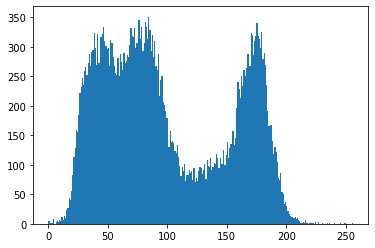

In [17]:
im = Image.open("001.tif")
#im.show()
imarray = np.array(im)
print(type(imarray))
plt.hist(imarray.ravel(),256,[0,256]); plt.show()

In [ ]:

length = len(mag_fullarray)
print("length",length)
for i in range (length):
    print(i)
    mag_array = mag_fullarray[i] 
    img = images[i+1]
    #im1array = cv2.imread(img)
    im = Image.open(img)
    imarray = np.array(im)
    image_array = np.asfarray(imarray).flatten().reshape((158,238))
    plt.subplot(2,2,1)
    plt.imshow(image_array)
    plt.title("Image")
    
    plt.subplot(2,2,2)
    plt.hist(mag_array,bins=22)
    plt.title("Histogram")
    
    plt.savefig('C:/Users/tetal/AI/Test001/New/00%s.png' %(i+1))
    #plt.show()
    #plt.imshow(image_array)

length 199
0
1


C:\Users\tetal\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\tetal\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tetal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-d28eab09612f>", line 19, in <module>
    plt.savefig('C:/Users/tetal/AI/Test001/New/00%s.png' %(i+1))
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\pyplot.py", line 723, in savefig
    fig.canvas.draw_idle()   # need this if 'transparent=True' to reset colors
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1907, in draw_idle
    self.draw(*args, **kwargs)
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\Users\tetal\Anaconda3\lib\site-packages\matplotlib\figure.py"

KeyboardInterrupt: 

In [ ]:
min = 0
max = 0
length = len(mag_fullarray)
print("length",length)
for i in range (length):
print(i)

In [16]:
print(mag_array.size)
print(mag_array[0][237])

37604
0.6069918


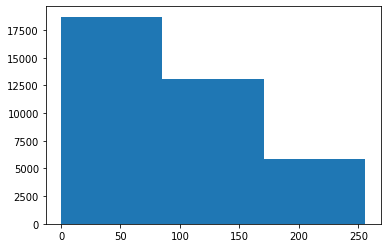

In [22]:

img = cv2.imread('001.tif',0)
plt.hist(img.ravel(),3,[0,256]); plt.show()